# Inspect tables with direct emissions data and food items

This will determine the food items to focus on IN ALL THE PROJECT

In notebook eze_tables_explore\03_identify_tables_type.ipynb I identified this tables:

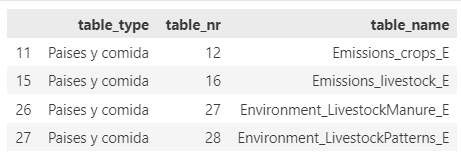

In [56]:
import pandas as pd
import numpy as np
import zipfile
import io
import os

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [57]:
directory = r'..\data\FAOSTAT\all_raw'

In [58]:
selected_tables = [12, 16]#, 27, 28]

In [59]:
def load_fao_table(table_number, path):
    # Loop through all files in the directory
    for filename in os.listdir(path):
        # Extract the number from the start of the filename
        file_number_str = filename.split('-')[0]
        try:
            file_number = int(file_number_str)
            # Check if the number matches the table number
            if file_number == table_number:
                if filename.endswith(".zip"):
                    zip_path = os.path.join(path, filename)
                    print(f"Found matching file: {filename}")

                    # Open the zip file
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        # List all files in the zip archive
                        all_files = zip_ref.namelist()
                        
                        # Iterate through the file names in the zip archive
                        for file_name in all_files:
                            # Check if the file name contains the pattern "All_Data_" and ends with .csv
                            if "All_Data" in file_name and file_name.endswith(".csv"):
                                print(f"Found matching file: {file_name}")
                                # Read the CSV file into a DataFrame
                                with zip_ref.open(file_name) as file:
                                    df = pd.read_csv(file, encoding="ISO-8859-1")
                                return df

                elif filename.endswith(".csv"):
                    csv_path = os.path.join(path, filename)
                    print(f"Found matching file: {filename}")
                    # Read the CSV file into a DataFrame
                    df = pd.read_csv(csv_path, encoding="ISO-8859-1")
                    return df

        except ValueError:
            # Handle the case where the filename doesn't start with a valid number
            pass
    
    # Return None if no matching file is found
    return None


In [60]:
for table in selected_tables:
    df = load_fao_table(table, directory)
    print(df.groupby('Item')['Element'].value_counts().to_frame().sort_values(by = 'count', ascending=False))
    print('\n', df['Item'].unique())
    print('\n', 'number of unique items:', len(df['Item'].unique()))
    print('\n')

Found matching file: 12-sample_Emissions_crops_E_All_Data_(Normalized).zip
Found matching file: Emissions_crops_E_All_Data_(Normalized).csv
                                                  count
Item      Element                                      
All Crops Crops total (Emissions N2O)             14528
          Crop residues (Direct emissions N2O)    14460
          Crop residues (N content)               14448
          Burning crop residues (Emissions CH4)   14417
          Crops total (Emissions CH4)             14417
...                                                 ...
Rye       Crops total (Emissions N2O)              5005
          Crop residues (Emissions N2O)            5005
          Crop residues (Indirect emissions N2O)   4792
          Crop residues (Direct emissions N2O)     4792
          Crop residues (N content)                4792

[92 rows x 1 columns]

 ['Barley' 'Maize (corn)' 'Sugar cane' 'Millet' 'Potatoes' 'Rice' 'Wheat'
 'All Crops' 'Nutrient nitrogen N 

# Create merged table of these 4 tables with crops and livestock

En cuanto a datos de emisiones, solo hay datos de animales y cosechas de cereales. No hay frutas u otros vegetales ni productos procesados.

### This is the code to see the proccessing of one table

In [61]:
selected_tables = [12, 16]

In [62]:
directory = r'..\data\FAOSTAT\all_raw'

In [63]:
"""
# Load the data
df = load_fao_table(16, directory)

# Replace spaces and commas in column names
cols_with_spaces = ['Element', 'Unit']
for col in cols_with_spaces:
    df[col] = df[col].str.replace(' ', '_').str.replace(',', '_')

# Combine 'Element' and 'Unit' columns
df['Element'] = df['Element'] + "_(" + df['Unit'] + ")"

# Calculate the availability of each Element across Items
element_item_counts = df.groupby('Element')['Item'].nunique()

# Calculate the total number of unique Items
total_items = df['Item'].nunique()

# Filter Elements that are available for more than 80% of Items
threshold = 0.8
elements_to_keep = element_item_counts[element_item_counts / total_items > threshold].index

# Filter the dataframe to keep only the desired Elements
df = df[df['Element'].isin(elements_to_keep)].reset_index(drop=True)

# Group by Area, Year, Item, and Element, then sum the values
grouped = df.groupby(['Area', 'Year', 'Item', 'Element'])['Value'].sum().reset_index()

# Pivot the table to have combinations of Items and Elements as columns
pivot_df = grouped.pivot_table(index=['Area', 'Year', 'Item'], 
                                columns=['Element'], 
                                values='Value', 
                                aggfunc='sum').reset_index()

pivot_df
"""

'\n# Load the data\ndf = load_fao_table(16, directory)\n\n# Replace spaces and commas in column names\ncols_with_spaces = [\'Element\', \'Unit\']\nfor col in cols_with_spaces:\n    df[col] = df[col].str.replace(\' \', \'_\').str.replace(\',\', \'_\')\n\n# Combine \'Element\' and \'Unit\' columns\ndf[\'Element\'] = df[\'Element\'] + "_(" + df[\'Unit\'] + ")"\n\n# Calculate the availability of each Element across Items\nelement_item_counts = df.groupby(\'Element\')[\'Item\'].nunique()\n\n# Calculate the total number of unique Items\ntotal_items = df[\'Item\'].nunique()\n\n# Filter Elements that are available for more than 80% of Items\nthreshold = 0.8\nelements_to_keep = element_item_counts[element_item_counts / total_items > threshold].index\n\n# Filter the dataframe to keep only the desired Elements\ndf = df[df[\'Element\'].isin(elements_to_keep)].reset_index(drop=True)\n\n# Group by Area, Year, Item, and Element, then sum the values\ngrouped = df.groupby([\'Area\', \'Year\', \'Item\',

### This is the code to proccess all tables and merge

I merged in the end only emissions tables.

From here we select FOOD ITEMS.

In [64]:
merged_df = pd.DataFrame()

for table in selected_tables:
    # Load the data
    df = load_fao_table(table, directory)

    # Replace spaces and commas in column names
    cols_with_spaces = ['Element', 'Unit']
    for col in cols_with_spaces:
        df[col] = df[col].str.replace(' ', '_').str.replace(',', '_')

    # Combine 'Element' and 'Unit' columns
    df['Element'] = df['Element'] + "_(" + df['Unit'] + ")"

    # Calculate the availability of each Element across Items
    element_item_counts = df.groupby('Element')['Item'].nunique()

    # Calculate the total number of unique Items
    total_items = df['Item'].nunique()

    # Filter Elements that are available for more than 80% of Items
    threshold = 0
    elements_to_keep = element_item_counts[element_item_counts / total_items > threshold].index

    # Filter the dataframe to keep only the desired Elements
    df = df[df['Element'].isin(elements_to_keep)].reset_index(drop=True)

    # Group by Area, Year, Item, and Element, then sum the values
    grouped = df.groupby(['Area Code', 'Area', 'Year', 'Item Code', 'Item', 'Element'])['Value'].sum().reset_index()

    # Pivot the table to have combinations of Items and Elements as columns
    pivot_df = grouped.pivot_table(index=['Area Code', 'Area', 'Year', 'Item Code', 'Item'], 
                                    columns=['Element'], 
                                    values='Value', 
                                    aggfunc='sum').reset_index()

    if merged_df.empty:
        merged_df = pivot_df
    else:
        merged_df = pd.merge(merged_df, pivot_df, on=['Area Code', 'Area', 'Year', 'Item Code', 'Item'], how='outer')

Found matching file: 12-sample_Emissions_crops_E_All_Data_(Normalized).zip
Found matching file: Emissions_crops_E_All_Data_(Normalized).csv
Found matching file: 16-sample_Emissions_livestock_E_All_Data_(Normalized).zip
Found matching file: Emissions_livestock_E_All_Data_(Normalized).csv


In [65]:
merged_df

Element,Area Code,Area,Year,Item Code,Item,Area_harvested_(ha),Burning_crop_residues_(Biomass_burned__dry_matter)_(t),Burning_crop_residues_(Emissions_CH4)_(kt),Burning_crop_residues_(Emissions_N2O)_(kt),Crop_residues_(Direct_emissions_N2O)_(kt),...,Manure_left_on_pasture_(Indirect_emissions_N2O)_(kt),Manure_left_on_pasture_(N_content)_(kg),Manure_left_on_pasture_that_leaches_(N_content)_(kg),Manure_left_on_pasture_that_volatilises_(N_content)_(kg),Manure_management_(Direct_emissions_N2O)_(kt),Manure_management_(Emissions_CH4)_(kt),Manure_management_(Emissions_N2O)_(kt),Manure_management_(Indirect_emissions_N2O)_(kt),Manure_management_(manure_treated__N_content)_(kg),Stocks_(An)
0,1,Armenia,1992,15,Wheat,NaN,26200.0,0.0707,0.0018,0.0301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Armenia,1992,44,Barley,NaN,NaN,NaN,NaN,0.0331,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Armenia,1992,56,Maize (corn),NaN,1297.0,0.0035,0.0001,0.0006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Armenia,1992,71,Rye,NaN,NaN,NaN,NaN,0.0003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Armenia,1992,75,Oats,NaN,NaN,NaN,NaN,0.0005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383997,5873,OECD,2050,1757,Cattle,NaN,NaN,NaN,NaN,NaN,...,68.2668,1.022176e+10,3.066528e+09,2.044352e+09,69.3325,1782.5531,96.9212,27.5887,6.287675e+09,3.070790e+08
383998,5873,OECD,2050,1759,Mules and Asses,NaN,NaN,NaN,NaN,NaN,...,1.0539,1.577960e+08,4.733879e+07,3.155920e+07,0.0136,6.5763,0.0136,0.0000,1.736282e+06,7.530187e+06
383999,5873,OECD,2050,1760,Camels and Llamas,NaN,NaN,NaN,NaN,NaN,...,0.0015,2.256498e+05,6.769493e+04,4.512995e+04,0.0000,0.0113,0.0000,0.0000,0.000000e+00,6.193000e+03
384000,5873,OECD,2050,2029,Poultry Birds,NaN,NaN,NaN,NaN,NaN,...,3.5945,5.382089e+08,1.614627e+08,1.076418e+08,17.8930,264.1721,18.2752,0.3823,2.326648e+09,5.925554e+09


In [66]:
merged_df['Item'].unique()

array(['Wheat', 'Barley', 'Maize (corn)', 'Rye', 'Oats', 'Potatoes',
       'Beans, dry', 'Buffalo', 'Cattle, dairy', 'Cattle, non-dairy',
       'Sheep', 'Goats', 'Swine', 'Swine, market', 'Swine, breeding',
       'Chickens, layers', 'Chickens, broilers', 'Chickens', 'Turkeys',
       'Horses', 'Asses', 'Mules and hinnies', 'All Crops',
       'Sheep and Goats', 'All Animals', 'Cattle', 'Mules and Asses',
       'Poultry Birds', 'Nutrient nitrogen N (total)', 'Rice', 'Millet',
       'Sugar cane', 'Camels', 'Camels and Llamas', 'Sorghum',
       'Soya beans', 'Ducks', 'Llamas'], dtype=object)

In [67]:
merged_df.columns

Index(['Area Code', 'Area', 'Year', 'Item Code', 'Item', 'Area_harvested_(ha)',
       'Burning_crop_residues_(Biomass_burned__dry_matter)_(t)',
       'Burning_crop_residues_(Emissions_CH4)_(kt)',
       'Burning_crop_residues_(Emissions_N2O)_(kt)',
       'Crop_residues_(Direct_emissions_N2O)_(kt)',
       'Crop_residues_(Emissions_N2O)_(kt)',
       'Crop_residues_(Indirect_emissions_N2O)_(kt)',
       'Crop_residues_(N_content)_(kg)', 'Crops_total_(Emissions_CH4)_(kt)',
       'Crops_total_(Emissions_N2O)_(kt)',
       'Indirect_emissions_(N2O_that_leaches)_(Synthetic_fertilizers)_(kt)',
       'Indirect_emissions_(N2O_that_volatilises)_(Synthetic_fertilizers)_(kt)',
       'Nitrogen_fertilizer_content_applied_that_leaches_(kg)',
       'Nitrogen_fertilizer_content_applied_that_volatilises_(kg)',
       'Rice_cultivation_(Emissions_CH4)_(kt)',
       'Synthetic_fertilizers_(Agricultural_use)_(kg)',
       'Synthetic_fertilizers_(Direct_emissions_N2O)_(kt)',
       'Synthetic_fertil

In [68]:
merged_df.shape

(384002, 49)

# Select food items and relevant features

**Crops emissions:**

Crops_total_(Emissions_CH4)_(kt)

Crops_total_(Emissions_N2O)_(kt)

**Livestock emissions:**

Livestock_total_(Emissions_CH4)_(kt)	

Livestock_total_(Emissions_N2O)_(kt)	---> ESTO ES LA SUMA DE LAS SIGUIENTES 4

### Keep columns

In [69]:
core_columns = [
    'Area Code',
    'Area',
    'Year',
    'Item Code',
    'Item'
]

In [70]:
emission_columns = [
    'Crops_total_(Emissions_CH4)_(kt)',
    'Crops_total_(Emissions_N2O)_(kt)',
    'Livestock_total_(Emissions_CH4)_(kt)',
    'Livestock_total_(Emissions_N2O)_(kt)',
]

In [71]:
core_columns.extend(emission_columns)

In [72]:
merged_df2 = merged_df[core_columns]

### Drop "all crops" and keep most commonly consumed livestock

I also renamed some livestock items

In [73]:
items_crops = pd.read_csv(r'..\data\FAOSTAT\clean_data\Emissions_crops_E_ItemCodes.csv')
items_crops = items_crops[items_crops['Item Code']!= 1712] #delete "all crops"

In [74]:
items_crops = items_crops['Item Code'].to_list()

In [75]:
items_crops

[116, 15, 156, 176, 236, 27, 44, 56, 71, 75, 79, 83]

In [76]:
new_items_livestock = pd.read_csv(r'..\data\FAOSTAT\clean_data\Emissions_livestock_E_ItemCodes_new.csv')
new_items_livestock.dropna(subset='new_Item', inplace=True)

In [77]:
new_items_livestock

,Item Code,Item,new_Item
0,1016,Goats,Goats
1,1048,Swine,Swine
2,1049,Swine; market,Swine
3,1051,Swine; breeding,Swine
4,1052,Chickens; layers,Chickens; for eggs
5,1053,Chickens; broilers,Chickens; for meat
6,1054,Chickens,Chickens; for meat
7,1068,Ducks,Ducks
8,1079,Turkeys,Turkeys
16,1757,Cattle,Cattle; non-dairy


In [78]:
all_items = new_items_livestock['Item Code'].to_list() + items_crops

In [79]:
merged_df2 = merged_df2[merged_df2['Item Code'].isin(all_items)]

In [80]:
rename_dict = new_items_livestock.set_index('Item Code')['new_Item'].to_dict() #create dictionary to rename in emission table

In [81]:
merged_df2['Item'] = merged_df2['Item Code'].map(rename_dict).fillna(merged_df2['Item']) #rename items

In [82]:
merged_df2['Item'].unique()

array(['Wheat', 'Barley', 'Maize (corn)', 'Rye', 'Oats', 'Potatoes',
       'Beans, dry', 'Cattle; dairy', 'Cattle; non-dairy', 'Sheep',
       'Goats', 'Swine', 'Chickens; for eggs', 'Chickens; for meat',
       'Turkeys', 'Poultry Birds', 'Rice', 'Millet', 'Sugar cane',
       'Sorghum', 'Soya beans', 'Ducks'], dtype=object)

In [83]:
merged_df2.head()

Element,Area Code,Area,Year,Item Code,Item,Crops_total_(Emissions_CH4)_(kt),Crops_total_(Emissions_N2O)_(kt),Livestock_total_(Emissions_CH4)_(kt),Livestock_total_(Emissions_N2O)_(kt)
0,1,Armenia,1992,15,Wheat,0.0707,0.0386,NaN,NaN
1,1,Armenia,1992,44,Barley,NaN,0.0406,NaN,NaN
2,1,Armenia,1992,56,Maize (corn),0.0035,0.0008,NaN,NaN
3,1,Armenia,1992,71,Rye,NaN,0.0003,NaN,NaN
4,1,Armenia,1992,75,Oats,NaN,0.0006,NaN,NaN


In [85]:
merged_df2.columns

Index(['Area Code', 'Area', 'Year', 'Item Code', 'Item',
       'Crops_total_(Emissions_CH4)_(kt)', 'Crops_total_(Emissions_N2O)_(kt)',
       'Livestock_total_(Emissions_CH4)_(kt)',
       'Livestock_total_(Emissions_N2O)_(kt)'],
      dtype='object', name='Element')

In [84]:
merged_df2.to_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\tablas_emisiones\merged_food_emissions.parquet', index=False)